# Doc2Vec on the ArXiv abstract classification test
This notebook is derived from the Gensim Doc2Vec Tutorial doc2vec-lee.ipynb available in github in 
RaRe-Technologies/gensim/docs/notebooks/doc2vec-lee.ipynb.

Doc2Vec is gensim's document embedding function.  Here we see how well it can help classify science documents from the Cornell ArXiv.  We have 7K science abstracts, titles and category labels. 

First install gensim.  Uncomment the next line if the import fails.

In [ ]:
#!pip install gensim

In [5]:
import gensim
import os
import collections
import smart_open
import random
import matplotlib.pyplot as plt
%matplotlib inline
import json

## What is it?

Doc2Vec is an NLP tool for representing documents as a vector and is a generalizing of the Word2Vec method. This tutorial will serve as an introduction to Doc2Vec and present ways to train and assess a Doc2Vec model.

## Resources

* [Word2Vec Paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
* [Doc2Vec Paper](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)

## Getting Started

We will need the several files.

1. The document files.  https://SciEngCloud.github.io/arxiv_data/sciml_data_arvix.p
2. the category configuration files. There are two used here:

    https://SciEngCloud.github.io/arxiv_data/config/config_all4.json
    
    https://SciEngCloud.github.io/arxiv_data/config/config_phy.json

In [6]:
!wget https://SciEngCloud.github.io/arxiv_data/config/config_phy.json

--2017-09-21 15:24:24--  https://sciengcloud.github.io/arxiv_data/config/config_phy.json
Resolving sciengcloud.github.io (sciengcloud.github.io)... 151.101.33.147, 2a04:4e42:8::403
Connecting to sciengcloud.github.io (sciengcloud.github.io)|151.101.33.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1783 (1.7K) [application/json]
Saving to: ‘config_phy.json.5’

config_phy.json.5   100%[=====================>]   1.74K  --.-KB/s   in 0s     

2017-09-21 15:24:24 (56.9 MB/s) - ‘config_phy.json.5’ saved [1783/1783]



## Define a Function to Read and Preprocess Text

Below, we define a function to open the train/test file (with latin encoding), read the file line-by-line, pre-process each line using a simple gensim pre-processing tool (i.e., tokenize text into individual words, remove punctuation, set to lowercase, etc), and return a list of words. Note that, for a given file (aka corpus), each continuous line constitutes a single document and the length of each line (i.e., document) can vary. Also, to train the model, we'll need to associate a tag/number with each document of the training corpus. In our case, the tag is simply the zero-based line number.

The data used in this example is stored in a pickle file that contains the abstract, title and the ArXiv category tag (called sitename).  There are many categories and we shall group them into supercategories. 

In the first case we will use the supercategories of Physics, math, compsci, bio and finance.   we have a configuration file called config_all4.json and a function read_config that will load the list of categories and subtopics (the arxiv tags).   

In [7]:
import pickle

In [8]:
def load_docs(path, name):
    filename = path+name+".p"
    fileobj = open(filename, "rb")
    z = fileobj.read()
    lst = pickle.loads(str(z))
    titles = []
    sitenames = []
    abstracts = []
    for i in range(0, len(lst)):
        titles.extend([lst[i][0]])
        sitenames.extend([lst[i][1]])
        abstracts.extend([lst[i][2]])
        
    print("done loading "+filename)
    return abstracts, sitenames, titles

In [9]:
def read_config(subj, basepath):
    docpath =basepath +"config_"+subj+".json"
    with open(docpath, 'rb') as f:
        doc = f.read() 
    z =json.loads(doc)
    subject = z['subject']
    loadset = z['loadset']
    subtopics = []
    for w in z['supertopics']:
        subtopics.extend([(w[0], w[1])])
    return subject, loadset, subtopics


We will laoad the categories and then use a function make_topic_dict which will create a dictionary that allows us to map a arxiv tag to the subtopic name

In [10]:
subject, loadset, subtopics = read_config("all4", "./notebooks/")

In [11]:
def make_topic_dict(subtopics):
    dic  = {}
    for x in subtopics:
        maintop = x[0]
        subs = x[1]
        for s in subs:
            dic[s] = maintop
    return dic

In [12]:
topicdict = make_topic_dict(subtopics)

In [13]:
bstracts, sites, titles = load_docs("./", "sciml_data_arxiv")

done loading ./sciml_data_arxiv.p


In [14]:
print len(bstracts)

7109


In [15]:
topics = [x[0] for x in subtopics]
topics

[u'Physics', u'math', u'bio', u'compsci', u'finance']

In [16]:
import random

In [17]:
my_list = range(7108)
train_set = random.sample(my_list, 5000)

In [18]:
test_set = set(my_list)-set(train_set)

In [19]:
test_set = list(test_set)
len(test_set)

2108

In [20]:
test_abstracts = []
test_titles = []
test_sites = []
for i in test_set:
    test_abstracts.append(bstracts[i])
    test_titles.append(titles[i])
    test_sites.append(sites[i])
train_abstracts = []
train_titles = []
train_sites = []
for i in train_set:
    train_abstracts.append(bstracts[i])
    train_titles.append(titles[i])
    train_sites.append(sites[i])

### we must save these file so that they can be read using the gensim preprocessor

In [21]:
with open("sciml_train", 'wb') as f:
    for abs in train_abstracts:
        f.write(abs+ "\n")
with open("sciml_test", 'wb') as f:
    for abs in test_abstracts:
        f.write(abs+ "\n")

In [22]:
def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [23]:
train_corpus = list(read_corpus("sciml_train"))
test_corpus = list(read_corpus("sciml_test", tokens_only=True))

Let's take a look at the training corpus

In [24]:
len(train_corpus)

5000

In [25]:
train_corpus[:2]

[TaggedDocument(words=[u'photosynthetic', u'water', u'oxidation', u'is', u'fundamental', u'process', u'that', u'sustains', u'the', u'biosphere', u'mn', u'ca', u'cluster', u'embedded', u'in', u'the', u'photosystem', u'ii', u'protein', u'environment', u'is', u'responsible', u'for', u'the', u'production', u'of', u'atmospheric', u'oxygen', u'here', u'time', u'resolved', u'ray', u'emission', u'spectroscopy', u'xes', u'was', u'used', u'to', u'observe', u'the', u'process', u'of', u'oxygen', u'formation', u'in', u'real', u'time', u'these', u'experiments', u'reveal', u'that', u'the', u'oxygen', u'evolution', u'step', u'initiated', u'by', u'three', u'sequential', u'laser', u'flashes', u'is', u'accompanied', u'by', u'rapid', u'within', u'mu', u'changes', u'to', u'the', u'mn', u'beta', u'xes', u'spectrum', u'however', u'no', u'oxidation', u'of', u'the', u'mn', u'ca', u'core', u'above', u'the', u'all', u'mn', u'text', u'iv', u'state', u'was', u'detected', u'to', u'precede', u'bond', u'formation', u

And the testing corpus looks like this:

In [26]:
print(test_corpus[:2])

[[u'we', u'investigate', u'similarities', u'in', u'the', u'micro', u'structural', u'dynamics', u'between', u'externally', u'driven', u'and', u'actively', u'driven', u'nematics', u'walls', u'lines', u'of', u'strong', u'deformations', u'in', u'the', u'director', u'field', u'and', u'topological', u'defects', u'are', u'characteristic', u'features', u'of', u'an', u'active', u'nematic', u'similar', u'structures', u'form', u'in', u'driven', u'passive', u'nematics', u'when', u'there', u'are', u'inhomogeneities', u'in', u'imposed', u'velocity', u'gradients', u'due', u'to', u'non', u'linear', u'flow', u'fields', u'or', u'geometrical', u'constraints', u'specifically', u'pressure', u'driven', u'flow', u'of', u'tumbling', u'passive', u'nematic', u'in', u'an', u'expanding', u'contracting', u'channel', u'produces', u'walls', u'and', u'defects', u'similar', u'to', u'those', u'seen', u'in', u'active', u'nematics', u'we', u'also', u'study', u'the', u'response', u'of', u'active', u'nematics', u'to', u'ex

Notice that the testing corpus is just a list of lists and does not contain any tags.

## Training the Model

### Instantiate a Doc2Vec Object 

Now, we'll instantiate a Doc2Vec model with a vector size with 50 words and iterating over the training corpus 55 times. We set the minimum word count to 2 in order to give higher frequency words more weighting. Model accuracy can be improved by increasing the number of iterations but this generally increases the training time. Small datasets with short documents, like this one, can benefit from more training passes.

In [ ]:
model = gensim.models.doc2vec.Doc2Vec(size=50, min_count=2, iter=55)

### Build a Vocabulary

In [ ]:
model.build_vocab(train_corpus)

Essentially, the vocabulary is a dictionary (accessible via `model.wv.vocab`) of all of the unique words extracted from the training corpus along with the count (e.g., `model.wv.vocab['penalty'].count` for counts for the word `penalty`).

### Train

for this data set it takes about 2 min of user cpu time.

In [ ]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)

### Inferring a Vector

One important thing to note is that you can now infer a vector for any piece of text without having to re-train the model by passing a list of words to the `model.infer_vector` function. This vector can then be compared with other vectors via cosine similarity.

In [ ]:
model.infer_vector([u'deep', u'convolutional', u'neural', u'networks', u'cnn'])

## Assessing Model

To assess our new model, we'll first infer new vectors for each document of the training corpus, compare the inferred vectors with the training corpus, and then returning the rank of the document based on self-similarity. Basically, we're pretending as if the training corpus is some new unseen data and then seeing how they compare with the trained model. The expectation is that we've likely overfit our model (i.e., all of the ranks will be less than 2) and so we should be able to find similar documents very easily. Additionally, we'll keep track of the second ranks for a comparison of less similar documents. 

In [ ]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    second_ranks.append(sims[1])

Let's count how each document ranks with respect to the training corpus 

In [ ]:
collections.Counter(ranks)  # Results vary due to random seeding and very small corpus

Basically, greater than 90% of the inferred documents are found to be most similar to itself and about 10% of the time it is mistakenly most similar to another document. the checking of an inferred-vector against a training-vector is a sort of 'sanity check' as to whether the model is behaving in a usefully consistent manner, though not a real 'accuracy' value.

This is great and not entirely surprising. We can take a look at an example:

## Testing the Model

Using the same approach above, we'll infer the vector for a randomly chosen test document, and compare the document to our model by eye.

In [ ]:
doc_id = 0
text = "u'Einsteins', u'general', u'theory', u'of', u'relativity', u'explains', u'gravity', u'in', u'terms', u'of', u'the', u'curvature', u'of', u'space-time'"
inferred_vector = model.infer_vector(text)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print('Test Document ({}): «{}»\n'.format(doc_id, text))

for index in range(20):
    if sims[index][1] > 0.2:
        print('%s %s %s' % (sims[index], topicdict[train_sites[sims[index][0]]], train_titles[sims[index][0]]))

### Now let's create a score
We are going to compute a score for a document by taking the similarity measure for all training docs above a certain threshold and we add the scores in each of our classification categories.  This weighted total is not based on any  deep analysis and different variations are possible

In [27]:
import pandas as pd
import numpy as np

# model tester
the function test_model creates a confusion matrix for each of a test set against the training set.

In [28]:
def bestans(score, indexlist):
    ans = indexlist[0]
    for top in indexlist[1:]:
        if score[top] > score[ans]: ans = top
    if score[ans] == 0.0: ans = 'none'
    return ans

def test_model(threshold, model, topicdict, test_corpus, test_sites, train_corpus, train_sites, indexlist):
    v = len(indexlist)
    zer = np.zeros((v,v), dtype=float)
    df = pd.DataFrame(zer, index = indexlist, columns=indexlist)
    gotnone = 0
    gotother = 0
    gotnonelist = []
    gototherlist = []
    indexset = set(indexlist)
    istrain = (test_corpus  == train_corpus)
    for i in range(len(test_corpus)):
        inferred_vector = model.infer_vector(train_corpus[i].words,steps = 20, alpha = 0.2 ) if istrain \
            else model.infer_vector(test_corpus[i], steps = 20, alpha = 0.2)
        sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
        try:
            correct = topicdict[test_sites[i]]
            score = { z: 0.0 for z in indexlist}
            for index in range(20):
                if (sims[index][1] > threshold): 
                    try: 
                        top =  topicdict[train_sites[sims[index][0]]]
                        if top in indexset:
                            x = sims[index][1]
                            score[top]= score[top]+ x
                    except:
                        gotother += 1
            best = bestans(score, indexlist)
            if (best == 'none'): 
                gotnone += 1
                gotnonelist.append(i)
            else:
                df[best][correct] += 1
        except:
            gotother += 1
            gototherlist.append(i)
    print ("gotother ="+str(gotother))
    print ("none ="+str(gotnone))
    total = 0.
    tpos = 0.
    for top in indexlist:
        for t2 in indexlist:
            total += df[t2][top]
            if top == t2:
                tpos += df[t2][top]
    tposrate = tpos/total
    classified = total/len(test_sites)
    print("clasified fraction = "+ str(classified) + " true pos rate = "+ str(tposrate))
    tot = 0
    for top in indexlist:
        tot += df[top]
    for top in indexlist:
        df[top] = np.round(100*df[top]/tot, decimals= 0)
    return df, tposrate, classified, gotnonelist, gototherlist

Now for the confusion matrix of the test vs the training set.  each row corresponds to how element of the test set are predicted to be in the training set (the valuues are percentages).   note that "none" is the set of documents that did not have any elements of the test set that occured above the threshold.  "gotother" are documents that are not classified by arxiv in one of our five categories.   these are ones we just ignnore.

In [ ]:
indexlist = ["Physics", "bio", "compsci", "math", "finance"]
indexlist = topics
rates = [0.60, 0.625, 0.65, 0.675, 0.70, 0.725, 0.750, 0.775, 0.80]
posrate = np.zeros((len(rates)), dtype=float)
classified = np.zeros((len(rates)), dtype=float)
for i in range(len(rates)):
    print ("for rate "+str(rates[i]))
    df , posrate[i], classified[i], gotnonelist, gototherlist=  \
        test_model(rates[i], model, topicdict, test_corpus, test_sites, train_corpus, train_sites, indexlist)
df

The following plot show increased accuracy but with greatly diminished classification rates.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ax = plt.subplot(111)

t = rates
s = classified
u = posrate
cline, = plt.plot(t, s, lw=2)
pline, = plt.plot(t, u, lw=2)

#plt.ylim(-2,2)
plt.show()

In [ ]:
indexlist = topics
df , posrate_rate, classified_rate, gotnonelist, gototherlist=  \
        test_model(0.6, model, topicdict, test_corpus, test_sites, train_corpus, train_sites, indexlist)


In [ ]:
gotnonelist[0:40]

test_abstracts[8]

In [ ]:
inferred_vector = model.infer_vector(test_corpus[8])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[8]))+test_sites[8])

for index in range(20):
    if sims[index][1] > 0.5:
        print('%s %s %s' % (sims[index], topicdict[train_sites[sims[index][0]]], train_titles[sims[index][0]]))

now for the train vs train matrix.  with a high threshold these should be nearly 100% on the diagonal.  

In [ ]:
indexlist = topics
rates = [0.60, 0.625, 0.65, 0.675, 0.70, 0.725, 0.750, 0.775, 0.80]
posrate = np.zeros((len(rates)), dtype=float)
classified = np.zeros((len(rates)), dtype=float)
for i in range(len(rates)):
    print ("for rate "+str(rates[i]))
    df , posrate[i], classified[i], gotnonelist, gototherlist=  \
         test_model(rates[i], model, topicdict, train_corpus, train_sites, train_corpus, train_sites, indexlist)
df

In [ ]:

ax = plt.subplot(111)

t = rates
s = classified
u = posrate
cline, = plt.plot(t, s, lw=2)
pline, = plt.plot(t, u, lw=2)

#plt.ylim(-2,2)
plt.show()

### visualizing the embedding space
our embedding is a virtual 5000 by 50 matrix.   We can use TSNE to project it to a 2D space.  

In [29]:
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
N = 4999
c = np.array([0]*N)
x = []
i =0
for i in range(N):  #range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[i].words)
    x.append(inferred_vector)
    if (train_sites[i] =='nlin.CG') or (train_sites[i] == "none"):
        z = 'math'
    else:
        z = topicdict[train_sites[i]]
    if z == 'math':
        c[i] = 1
    elif z == 'Physics':
        c[i] = 2
    elif z == 'bio':
        c[i]= 3
    elif z == 'finance':
        c[i]= 4
    elif z == 'compsci':
        c[i]= 5
    #i = i+1

In [ ]:
w = np.array(x)

In [ ]:
RS =20150101
w_embedded = TSNE(random_state=RS).fit_transform(w)

In [ ]:
 w_embedded.shape

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(w_embedded[:,0], w_embedded[:,1], c = c)
plt.colorbar()
plt.grid

The most intresting thing in the above visualization is the two clusters of physics documents (2.0 on the color spectrum.) but the others are spread around.  


## Now repeat the process looking only at Physics papers.

In [30]:
phy_subject, phy_loadset, phy_subtopics = read_config("phy", "./")

In [33]:
phy_topics = [x[0] for x in phy_subtopics]
phy_topics
indexlist = phy_topics[0:7]

In [34]:
phy_topicdict = make_topic_dict(phy_subtopics)
phy_topicdict['cond-mat.dis-nn'] = 'Cond Matter' # a small fix.   this one was left out of the phy.json list

In [37]:
phy_abstracts = []
phy_sites = []
phy_titles = []
for i in range(7108):
    if sites[i] != 'none' and sites[i] != 'nlin.CG'  and topicdict[sites[i]] == 'Physics' and phy_topicdict[sites[i]] != 'other-phy':
        phy_sites.append(sites[i])
        phy_titles.append(titles[i])
        phy_abstracts.append(bstracts[i])

In [39]:
my_list = range(len(phy_titles))
phy_train_set = random.sample(my_list, 2000)
phy_test_set = set(my_list)-set(phy_train_set)
phy_test_set = list(phy_test_set)
len(phy_test_set)

794

In [40]:
phy_test_abstracts = []
phy_test_titles = []
phy_test_sites = []
for i in phy_test_set:
    phy_test_abstracts.append(phy_abstracts[i])
    phy_test_titles.append(phy_titles[i])
    phy_test_sites.append(phy_sites[i])
phy_train_abstracts = []
phy_train_titles = []
phy_train_sites = []
for i in phy_train_set:
    phy_train_abstracts.append(phy_abstracts[i])
    phy_train_titles.append(phy_titles[i])
    phy_train_sites.append(phy_sites[i])

In [41]:
with open("phy_sciml_train", 'wb') as f:
    for abs in phy_train_abstracts:
        f.write(abs+ "\n")
with open("phy_sciml_test", 'wb') as f:
    for abs in phy_test_abstracts:
        f.write(abs+ "\n")

In [42]:
phy_train = []
for i in range(len(phy_train_sites)):
    phy_train.append([phy_train_titles[i], phy_train_sites[i], phy_train_abstracts[i]])
    

In [43]:
phy_train[0][1]

'physics.flu-dyn'

In [44]:
pickle.dump( phy_train, open( "phy_train.p", "wb" ) )

In [45]:
phy_train_corpus = list(read_corpus("phy_sciml_train"))
phy_test_corpus = list(read_corpus("phy_sciml_test", tokens_only=True))

In [46]:
phy_model = gensim.models.doc2vec.Doc2Vec(size=50, min_count=2, iter=55)
phy_model.build_vocab(phy_train_corpus)

In [47]:
%time phy_model.train(phy_train_corpus, total_examples=phy_model.corpus_count, epochs=phy_model.iter)

CPU times: user 55.3 s, sys: 4.47 s, total: 59.8 s
Wall time: 28.1 s


13491944

In [48]:
train_doc_count =  {x: 0.0 for x in indexlist}
train_doc_list =  {x: [] for x in indexlist}
test_doc_list =  {x: [] for x in indexlist}
train_doc_count['other'] = 0.0
train_otherlist = []
for i in range(len(phy_train_sites)):
    try:
        train_doc_count[phy_topicdict[phy_train_sites[i]]]+=1
        train_doc_list[phy_topicdict[phy_train_sites[i]]].append(i)
    except:
        train_doc_count['other']+=1
        train_otherlist.append(i)
print "the train other list"
print train_doc_count
print len(train_otherlist)

test_doc_count =  {x: 0.0 for x in indexlist}
test_doc_count['other'] = 0.0
test_otherlist = []
for i in range(len(phy_test_sites)):
    try:
        test_doc_count[phy_topicdict[phy_test_sites[i]]]+=1
        test_doc_list[phy_topicdict[phy_train_sites[i]]].append(i)
    except:
        test_doc_count['other']+=1
        test_otherlist.append(i)
print "the test other list"
print test_doc_count
print len(test_otherlist)
gotest = set(test_otherlist)
gotrain = set(train_otherlist)

the train other list
{u'ed-physics': 162.0, u'Cond Matter': 145.0, u'GenRelQGr': 444.0, u'Astro': 734.0, u'quantum': 79.0, 'other': 0.0, u'MathPh': 141.0, u'high eng': 295.0}
0
the test other list
{u'ed-physics': 57.0, u'Cond Matter': 55.0, u'GenRelQGr': 173.0, u'Astro': 315.0, u'quantum': 26.0, 'other': 0.0, u'MathPh': 53.0, u'high eng': 115.0}
0


In [49]:
for x in indexlist:
    print x +  "  "+str(len(test_doc_list[x]))

Astro  288
GenRelQGr  166
Cond Matter  58
high eng  115
MathPh  62
quantum  35
ed-physics  70


This is the test using the doc2vec version of the classifier

In [105]:
indexlist = phy_topics[0:7]
print indexlist
rate = 0.60 #[0.60, 0.625, 0.65, 0.675, 0.70, 0.725, 0.750, 0.775, 0.80]
dftest ,posrate, classified, gotnonelist, gototherlist= test_model(rate, phy_model, phy_topicdict, phy_test_corpus, phy_test_sites, phy_train_corpus, phy_train_sites, indexlist)
dftest

[u'Astro', u'GenRelQGr', u'Cond Matter', u'high eng', u'MathPh', u'quantum', u'ed-physics']
gotother =0
none =343
clasified fraction = 0.568010075567 true pos rate = 0.660753880266


,Astro,GenRelQGr,Cond Matter,high eng,MathPh,quantum,ed-physics
Astro,89.0,5.0,2.0,2.0,0.0,0.0,3.0
GenRelQGr,18.0,64.0,0.0,12.0,4.0,1.0,1.0
Cond Matter,8.0,20.0,40.0,16.0,0.0,16.0,0.0
high eng,6.0,45.0,5.0,34.0,3.0,6.0,2.0
MathPh,0.0,31.0,28.0,7.0,28.0,3.0,3.0
quantum,0.0,18.0,9.0,18.0,9.0,45.0,0.0
ed-physics,0.0,2.0,10.0,7.0,0.0,5.0,76.0


In [50]:
indexlist = phy_topics[0:7]
rates = [0.60, 0.625, 0.65, 0.675, 0.70, 0.725, 0.750, 0.775, 0.80]
posrate = np.zeros((len(rates)), dtype=float)
classified = np.zeros((len(rates)), dtype=float)
for i in range(len(rates)):
    print ("for rate "+str(rates[i]))
    dftest ,posrate[i], classified[i], gotnonelist, gototherlist= test_model(rates[i], phy_model, phy_topicdict, phy_test_corpus, phy_test_sites, phy_train_corpus, phy_train_sites, indexlist)
dftest

for rate 0.6
gotother =0
none =345
clasified fraction = 0.565491183879 true pos rate = 0.650334075724
for rate 0.625
gotother =0
none =470
clasified fraction = 0.408060453401 true pos rate = 0.697530864198
for rate 0.65
gotother =0
none =586
clasified fraction = 0.261964735516 true pos rate = 0.701923076923
for rate 0.675
gotother =0
none =648
clasified fraction = 0.183879093199 true pos rate = 0.780821917808
for rate 0.7
gotother =0
none =694
clasified fraction = 0.125944584383 true pos rate = 0.85
for rate 0.725
gotother =0
none =715
clasified fraction = 0.0994962216625 true pos rate = 0.911392405063
for rate 0.75
gotother =0
none =726
clasified fraction = 0.0856423173804 true pos rate = 0.941176470588
for rate 0.775
gotother =0
none =730
clasified fraction = 0.080604534005 true pos rate = 1.0
for rate 0.8
gotother =0
none =733
clasified fraction = 0.0768261964736 true pos rate = 1.0


,Astro,GenRelQGr,Cond Matter,high eng,MathPh,quantum,ed-physics
Astro,100.0,0.0,0.0,0.0,0.0,0.0,0.0
GenRelQGr,0.0,100.0,0.0,0.0,0.0,0.0,0.0
Cond Matter,0.0,0.0,100.0,0.0,0.0,0.0,0.0
high eng,0.0,0.0,0.0,100.0,0.0,0.0,0.0
MathPh,0.0,0.0,0.0,0.0,100.0,0.0,0.0
quantum,0.0,0.0,0.0,0.0,0.0,100.0,0.0
ed-physics,0.0,0.0,0.0,0.0,0.0,0.0,100.0


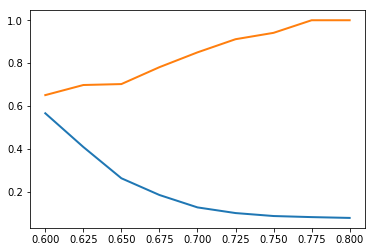

In [51]:
ax = plt.subplot(111)

t = rates
s = classified
u = posrate
cline, = plt.plot(t, s, lw=2)
pline, = plt.plot(t, u, lw=2)

#plt.ylim(-2,2)
plt.show()

In [52]:
none_test = gotnonelist
print len(phy_test_sites)-len(none_test)

61


In [53]:
print len(test_otherlist)
i = 0
for x in gotnonelist:
    if x in gotest:
        i = i+1
print i

0
0


Note that we see Astro physics is pretty easly identified, but General Relativity and high engery physics are easily confused.
We noted this fact on all of our previous classification experiments.   Also not that almost half (634) of the test set failed to 
have a document within the 0.65 range.


In [54]:
indexlist = phy_topics[0:7]
rates = [0.60, 0.625, 0.65, 0.675, 0.70, 0.725, 0.750, 0.775, 0.80]
posrate = np.zeros((len(rates)), dtype=float)
classified = np.zeros((len(rates)), dtype=float)
for i in range(len(rates)):
    print ("for rate "+str(rates[i]))
    dftest ,posrate[i], classified[i], gotnonelist, gototherlist= test_model(rates[i], phy_model, phy_topicdict, phy_train_corpus, phy_train_sites, phy_train_corpus, phy_train_sites, indexlist)
dftest

for rate 0.6
gotother =0
none =0
clasified fraction = 1.0 true pos rate = 0.7915
for rate 0.625
gotother =0
none =0
clasified fraction = 1.0 true pos rate = 0.848
for rate 0.65
gotother =0
none =0
clasified fraction = 1.0 true pos rate = 0.9075
for rate 0.675
gotother =0
none =2
clasified fraction = 0.999 true pos rate = 0.96046046046
for rate 0.7
gotother =0
none =3
clasified fraction = 0.9985 true pos rate = 0.978467701552
for rate 0.725
gotother =0
none =22
clasified fraction = 0.989 true pos rate = 0.988877654196
for rate 0.75
gotother =0
none =38
clasified fraction = 0.981 true pos rate = 0.998980632008
for rate 0.775
gotother =0
none =83
clasified fraction = 0.9585 true pos rate = 0.999478351591
for rate 0.8
gotother =0
none =192
clasified fraction = 0.904 true pos rate = 1.0


,Astro,GenRelQGr,Cond Matter,high eng,MathPh,quantum,ed-physics
Astro,100.0,0.0,0.0,0.0,0.0,0.0,0.0
GenRelQGr,0.0,100.0,0.0,0.0,0.0,0.0,0.0
Cond Matter,0.0,0.0,100.0,0.0,0.0,0.0,0.0
high eng,0.0,0.0,0.0,100.0,0.0,0.0,0.0
MathPh,0.0,0.0,0.0,0.0,100.0,0.0,0.0
quantum,0.0,0.0,0.0,0.0,0.0,100.0,0.0
ed-physics,0.0,0.0,0.0,0.0,0.0,0.0,100.0


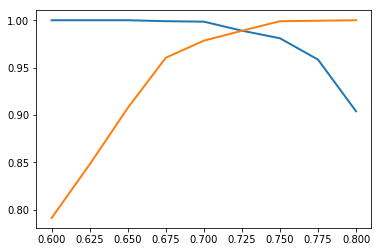

In [55]:
x = plt.subplot(111)

t = rates
s = classified
u = posrate
cline, = plt.plot(t, s, lw=2)
pline, = plt.plot(t, u, lw=2)

#plt.ylim(-2,2)
plt.show()

In [56]:
len(phy_train_corpus)

2000

In [58]:
N = 1999
c = np.array([0]*N)
x = []
i =0
for i in range(N):  #range(len(train_corpus)):
    inferred_vector = phy_model.infer_vector(phy_train_corpus[i].words)
    x.append(inferred_vector)
    if (phy_train_sites[i] =='nlin.CG') or (phy_train_sites[i] == "none"):
        z = 'ed-physics'
    else:
        z = phy_topicdict[phy_train_sites[i]]
    #print z
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            c[i] = j
cold = c

In [59]:
w = np.array(x)
RS =20150101
w_embedded = TSNE(random_state=RS).fit_transform(w)
w_embedded.shape

(1999, 2)

<function matplotlib.pyplot.grid>

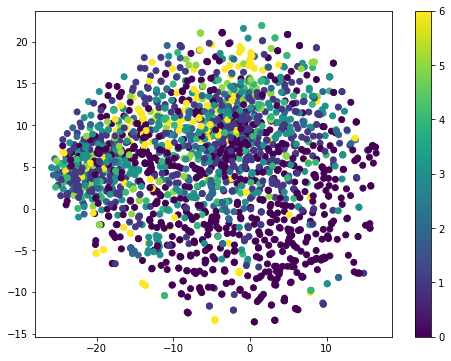

In [60]:
plt.figure(figsize=(8,6))
plt.scatter(w_embedded[:,0], w_embedded[:,1], c = c)
plt.colorbar()
plt.grid

Again the only thing interesting here is the way astrophysics is a clear cluster.  everything else is spread around.

In [61]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier


In [62]:
a = phy_model.docvecs

In [63]:
a[0]

array([ 0.70089364, -0.21496131,  0.65399545, -0.39224419, -0.34866181,
        0.70728356,  0.2870945 , -1.62007761, -0.48366401, -0.07942587,
       -0.18353277,  0.57799125,  0.50682646, -0.41240433,  1.71568525,
        0.92046624, -3.00247812,  0.04818186, -1.70467103,  0.80643272,
        0.39295381,  0.3874512 ,  0.1995682 ,  0.95303643,  0.73628443,
        1.05776429, -0.53782409, -0.30147108, -0.5901292 , -1.12162769,
        0.58742917,  1.47967505,  0.6383273 , -0.69966573,  0.3252596 ,
       -0.40519831,  0.36379787,  0.96413183,  0.2047082 , -0.99923462,
        0.37271392, -0.74735063,  0.49446741,  0.42120898,  0.17047584,
       -0.82198519,  0.35625628,  0.15148826,  0.32985136, -1.03670192], dtype=float32)

In [64]:
m = a.doctag_syn0

In [65]:
sims = a.most_similar(155)

In [66]:
sims

[(670, 0.7162301540374756),
 (628, 0.7089747190475464),
 (1660, 0.6939022541046143),
 (1450, 0.6767436265945435),
 (1264, 0.6635294556617737),
 (1747, 0.6436527967453003),
 (664, 0.6330532431602478),
 (864, 0.6087887287139893),
 (47, 0.6056168675422668),
 (969, 0.6041465997695923)]

In [67]:
phy_train_titles[155]

u'Weak lensing induced by second-order vector mode [astro-ph.CO]'

In [68]:
[phy_train_titles[x[0]] for x in sims]

[u'Searching for Features of a String Inspired Inflationary Model with   Cosmological Observations [astro-ph.CO]',
 u'Searching for Features of a String Inspired Inflationary Model with   Cosmological Observations [astro-ph.CO]',
 u'Gauge Invariant Cosmological Perturbations in Teleparallel Gravity [gr-qc]',
 u'On the coupling of vector fields to the Gauss-Bonnet invariant [gr-qc]',
 u'Dark energy and non-linear power spectrum [astro-ph.CO]',
 u'Bubble Expansion and the Viability of Singlet-Driven Electroweak   Baryogenesis [hep-ph]',
 u'Parity-violating CMB correlators with non-decaying statistical   anisotropy [astro-ph.CO]',
 u'Fine Tuning May Not Be Enough [astro-ph.CO]',
 u'Removing Ostrogradski&#x27;s ghost from cosmological perturbations in   $f(R,R_{\\mu\\nu}^2,C_{\\mu\\nu\\rho\\sigma}^2)$ gravity [gr-qc]',
 u'Inflationary Magnetogenesis in $R^{2}$-Inflation after Planck 2015 [astro-ph.CO]']

In [69]:
#!pip install xgboost

In [70]:
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [71]:
#classifier = svm.SVC(gamma=0.1)
#classifier = RandomForestClassifier(n_estimators = 100)
#classifier = MLPClassifier(hidden_layer_sizes=(1000,), epsilon=1e-10, tol=0.000001,max_iter=1000)
#classifier = KNeighborsClassifier(p = 3)
count_vect = CountVectorizer()
training_set_data = np.array(phy_train_abstracts)
X_train_counts = count_vect.fit_transform(training_set_data)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
classifier = RandomForestClassifier(n_estimators = 100)
N = len(phy_train_sites)
target = np.array([0]*N)
for i in range(len(phy_train_sites)):
    z= phy_topicdict[phy_train_sites[i]]
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            target[i] = j    
classifier.fit(X_train_tfidf, target)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [72]:
X_train_tfidf.shape

(2000, 15568)

In [73]:
X_train_tfidf[20]

<1x15568 sparse matrix of type '<type 'numpy.float64'>'
	with 151 stored elements in Compressed Sparse Row format>

In [74]:
predicted = classifier.predict(X_train_tfidf)

In [75]:
print len(predicted)
predicted[20:30]

2000


array([1, 3, 6, 0, 0, 0, 0, 4, 0, 0])

In [76]:
print len(cold)
cold[:-10]

1999


array([4, 6, 0, ..., 0, 4, 2])

In [77]:
v = len(indexlist)
zer = np.zeros((v,v), dtype=float)
df = pd.DataFrame(zer, index = indexlist, columns=indexlist)
gotnone = 0
gotother = 0
N = len(phy_train_sites)
c = np.array([0]*N)
for i in range(len(phy_train_sites)):
    z= phy_topicdict[phy_train_sites[i]]
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            c[i] = j
            
for i in range(len(phy_train_sites)):
    try:
        x = indexlist[c[i]]
        y = indexlist[predicted[i]]
        df[y][x]+= 1
    except:
        gotnone +=1
tot = 0
for top in indexlist:
    tot += df[top]
for top in indexlist:
    df[top] = np.round(100*df[top]/tot, decimals= 0)


In [78]:
df

,Astro,GenRelQGr,Cond Matter,high eng,MathPh,quantum,ed-physics
Astro,100.0,0.0,0.0,0.0,0.0,0.0,0.0
GenRelQGr,0.0,100.0,0.0,0.0,0.0,0.0,0.0
Cond Matter,0.0,0.0,100.0,0.0,0.0,0.0,0.0
high eng,0.0,0.0,0.0,100.0,0.0,0.0,0.0
MathPh,0.0,0.0,0.0,0.0,100.0,0.0,0.0
quantum,0.0,0.0,0.0,0.0,0.0,100.0,0.0
ed-physics,0.0,0.0,0.0,0.0,0.0,0.0,100.0


In [79]:
gotnone

0

In [80]:
test_set_data = np.array(phy_test_abstracts)
X_test_counts = count_vect.transform(phy_test_abstracts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
N = len(phy_test_sites)
c = np.array([0]*N)
for i in range(len(phy_test_sites)):
    z= phy_topicdict[phy_test_sites[i]]
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            c[i] = j    
    

In [81]:
print len(c)
print X_test_tfidf.shape

794
(794, 15568)


In [82]:
predicted = classifier.predict(X_test_tfidf)
len(predicted)

794

In [83]:
v = len(indexlist)
zer = np.zeros((v,v), dtype=float)
df = pd.DataFrame(zer, index = indexlist, columns=indexlist)
gotnone = 0
gotother = 0
N = len(phy_test_sites)
c = np.array([0]*N)
for i in range(len(phy_test_sites)):
    z= phy_topicdict[phy_test_sites[i]]
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            c[i] = j

for i in range(1114):
    #if (i not in gotest) and (i not in gntest):
    try:
        x = indexlist[c[i]]
        y = indexlist[predicted[i]]
        df[y][x]+= 1
    except:
        gotnone +=1
tot = 0
#remove most of the Astro cases
print df
for top in indexlist:
    tot += df[top]
for top in indexlist:
    df[top] = np.round(100*df[top]/tot, decimals= 0)
df

             Astro  GenRelQGr  Cond Matter  high eng  MathPh  quantum  \
Astro        299.0       16.0          0.0       0.0     0.0      0.0   
GenRelQGr     16.0      155.0          0.0       2.0     0.0      0.0   
Cond Matter   31.0       15.0          7.0       1.0     0.0      0.0   
high eng      34.0       52.0          0.0      28.0     0.0      1.0   
MathPh        17.0       25.0          1.0       2.0     7.0      0.0   
quantum        4.0       10.0          0.0       3.0     0.0      7.0   
ed-physics    28.0        6.0          0.0       1.0     0.0      0.0   

             ed-physics  
Astro               0.0  
GenRelQGr           0.0  
Cond Matter         1.0  
high eng            0.0  
MathPh              1.0  
quantum             2.0  
ed-physics         22.0  


,Astro,GenRelQGr,Cond Matter,high eng,MathPh,quantum,ed-physics
Astro,95.0,5.0,0.0,0.0,0.0,0.0,0.0
GenRelQGr,9.0,90.0,0.0,1.0,0.0,0.0,0.0
Cond Matter,56.0,27.0,13.0,2.0,0.0,0.0,2.0
high eng,30.0,45.0,0.0,24.0,0.0,1.0,0.0
MathPh,32.0,47.0,2.0,4.0,13.0,0.0,2.0
quantum,15.0,38.0,0.0,12.0,0.0,27.0,8.0
ed-physics,49.0,11.0,0.0,2.0,0.0,0.0,39.0


In [84]:
gotnone

320

In [85]:
from predictor import predictor

In [86]:
pred = predictor()

init done


predict returns:  randomforest, best, sencondbest, centroid, true

In [87]:
pred.predict(phy_train_abstracts[13], phy_train_sites[13])

(u'GenRelQGr', u'GenRelQGr', u'GenRelQGr', u'GenRelQGr', u'GenRelQGr')

In [88]:
v = len(indexlist)
zer = np.zeros((v,v), dtype=float)
dfp = pd.DataFrame(zer, index = indexlist, columns=indexlist)
c = np.array([0]*len(phy_train_sites))

gotnone = 0
gotother = 0
for i in range(len(phy_train_sites)):       
    z = phy_topicdict[phy_train_sites[i]]
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            c[i] = j

for i in range(len(phy_train_abstracts)):
    if (i not in gotrain): 
        x = indexlist[c[i]]
        p = pred.predict(phy_train_abstracts[i], phy_train_sites[i])
        #print p
        for j in range(len(indexlist)):
            if p[1] == indexlist[j]:
                pr = j
        y = indexlist[pr]
        dfp[y][x]+= 1
tot = 0
for top in indexlist:
    tot += dfp[top]
for top in indexlist:
    dfp[top] = np.round(100*dfp[top]/tot, decimals= 0)
dfp

,Astro,GenRelQGr,Cond Matter,high eng,MathPh,quantum,ed-physics
Astro,94.0,3.0,1.0,1.0,1.0,0.0,0.0
GenRelQGr,5.0,86.0,0.0,5.0,2.0,2.0,0.0
Cond Matter,5.0,6.0,70.0,3.0,6.0,6.0,5.0
high eng,6.0,14.0,2.0,72.0,2.0,3.0,1.0
MathPh,4.0,4.0,5.0,9.0,74.0,2.0,2.0
quantum,4.0,5.0,1.0,6.0,9.0,72.0,3.0
ed-physics,1.0,3.0,4.0,3.0,5.0,2.0,82.0


In [91]:
gotestl = []
for i in range(len(phy_test_sites)):
    if phy_topicdict[phy_test_sites[i]] == 'other-phy':
        gotestl.append(i)
gotest = set(gotestl)

In [99]:
v = len(indexlist)
zer = np.zeros((v,v), dtype=float)
dfpt = pd.DataFrame(zer, index = indexlist, columns=indexlist)
c = np.array([0]*len(phy_test_sites))

gotnone = 0
gotother = 0
for i in range(len(phy_test_sites)):       
    z = phy_topicdict[phy_test_sites[i]]
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            c[i] = j

for i in range(len(phy_test_abstracts)):
    if (i not in gotest): # and (i not in gntest):
        x = indexlist[c[i]]
        p = pred.predict(phy_test_abstracts[i], phy_test_sites[i])
        #print p
        for j in range(len(indexlist)):
            if p[1] == indexlist[j]:
                pr = j
        y = indexlist[pr]
        dfpt[y][x]+= 1
#print(dfpt)
tot = 0
for top in indexlist:
    tot += dfpt[top]
for top in indexlist:
    dfpt[top] = np.round(100*dfpt[top]/tot, decimals= 0)
dfpt

,Astro,GenRelQGr,Cond Matter,high eng,MathPh,quantum,ed-physics
Astro,90.0,3.0,1.0,3.0,1.0,1.0,1.0
GenRelQGr,5.0,83.0,1.0,8.0,1.0,2.0,1.0
Cond Matter,11.0,5.0,73.0,7.0,2.0,0.0,2.0
high eng,7.0,11.0,1.0,77.0,0.0,2.0,2.0
MathPh,2.0,6.0,6.0,9.0,74.0,2.0,2.0
quantum,0.0,4.0,4.0,4.0,0.0,77.0,12.0
ed-physics,4.0,2.0,0.0,2.0,2.0,0.0,91.0


In [95]:
print len(phy_train_abstracts)

2000


now do it again with random forest

In [97]:
v = len(indexlist)
zer = np.zeros((v,v), dtype=float)
dfpt = pd.DataFrame(zer, index = indexlist, columns=indexlist)
c = np.array([0]*len(phy_test_sites))

gotnone = 0
gotother = 0
c 
for i in range(len(phy_test_sites)):       
    z = phy_topicdict[phy_test_sites[i]]
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            c[i] = j

for i in range(len(phy_test_abstracts)):
    x = indexlist[c[i]]
    p = pred.predict(phy_test_abstracts[i], phy_test_sites[i])
    #print p
    for j in range(len(indexlist)):
        if p[0] == indexlist[j]:
            pr = j
    y = indexlist[pr]
    dfpt[y][x]+= 1
tot = 0
for top in indexlist:
    tot += dfpt[top]
for top in indexlist:
    dfpt[top] = np.round(100*dfpt[top]/tot, decimals= 0)
dfpt

,Astro,GenRelQGr,Cond Matter,high eng,MathPh,quantum,ed-physics
Astro,95.0,4.0,0.0,0.0,0.0,0.0,0.0
GenRelQGr,5.0,95.0,0.0,0.0,1.0,0.0,0.0
Cond Matter,31.0,9.0,58.0,2.0,0.0,0.0,0.0
high eng,10.0,28.0,0.0,60.0,1.0,1.0,0.0
MathPh,9.0,19.0,0.0,4.0,66.0,0.0,2.0
quantum,0.0,8.0,0.0,8.0,0.0,81.0,4.0
ed-physics,12.0,4.0,2.0,2.0,2.0,0.0,79.0


In [ ]:
classifier = MLPClassifier(hidden_layer_sizes=(1000,), epsilon=1e-10, tol=0.000001,max_iter=1000)

In [ ]:
N = len(phy_train_sites)
target = np.array([0]*N)
x = []
for i in range(len(phy_train_sites)):
    z= phy_topicdict[phy_train_sites[i]]
    x.append(phy_train_abstracts[i])
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            target[i] = j  
a = phy_model.docvecs
m = a.doctag_syn0
classifier.fit(m, target)


In [ ]:
predicted = classifier.predict(m)
len(predicted)

In [ ]:
v = len(indexlist)
zer = np.zeros((v,v), dtype=float)
df = pd.DataFrame(zer, index = indexlist, columns=indexlist)
gotnone = 0
gotother = 0
c = np.array([0]*len(phy_train_sites))

gotnone = 0
gotother = 0
for i in range(len(phy_train_sites)):       
    z = phy_topicdict[phy_train_sites[i]]
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            c[i] = j

for i in range(1114):
    if (i not in gotrain): # and (i not in gntest):
        try:
            x = indexlist[c[i]]
            y = indexlist[predicted[i]]
            df[y][x]+= 1
        except:
            gotnone +=1
tot = 0
#remove most of the Astro cases

for top in indexlist:
    tot += df[top]
for top in indexlist:
    df[top] = np.round(100*df[top]/tot, decimals= 0)
df

In [ ]:
N = len(phy_test_corpus)
print N
c = np.array([0]*N)
x = []
i =0
for i in range(N):  #range(len(train_corpus)):
    inferred_vector = model.infer_vector(phy_test_corpus[i])
    x.append(inferred_vector)
    try:
        z = phy_topicdict[phy_train_sites[i]]
        for j in range(len(indexlist)):
            if z == indexlist[j]:
                c[i] = j
    except:
        c[i] = 7


In [ ]:
v = np.array(x)
predicted = classifier.predict(v)
len(predicted)

In [ ]:
v = len(indexlist)
zer = np.zeros((v,v), dtype=float)
df = pd.DataFrame(zer, index = indexlist, columns=indexlist)
gotnone = 0
gotother = 0
c = np.array([0]*len(phy_test_sites))

gotnone = 0
gotother = 0
for i in range(len(phy_test_sites)):       
    z = phy_topicdict[phy_test_sites[i]]
    for j in range(len(indexlist)):
        if z == indexlist[j]:
            c[i] = j

for i in range(1114):
    if (i not in gotest)and (i not in set(none_test)):
        try:
            x = indexlist[c[i]]
            y = indexlist[predicted[i]]
            df[y][x]+= 1
        except:
            gotnone +=1
tot = 0
#remove most of the Astro cases

for top in indexlist:
    tot += df[top]
for top in indexlist:
    df[top] = np.round(100*df[top]/tot, decimals= 0)
df

In [ ]:
gotnone

In [ ]:
gotother